<a href="https://colab.research.google.com/github/ShotaSasaki-HCU/Prog2kakushin/blob/main/work2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

シミュレーション結果を保存します。
ファイル名（拡張子を除く）：uygyu565


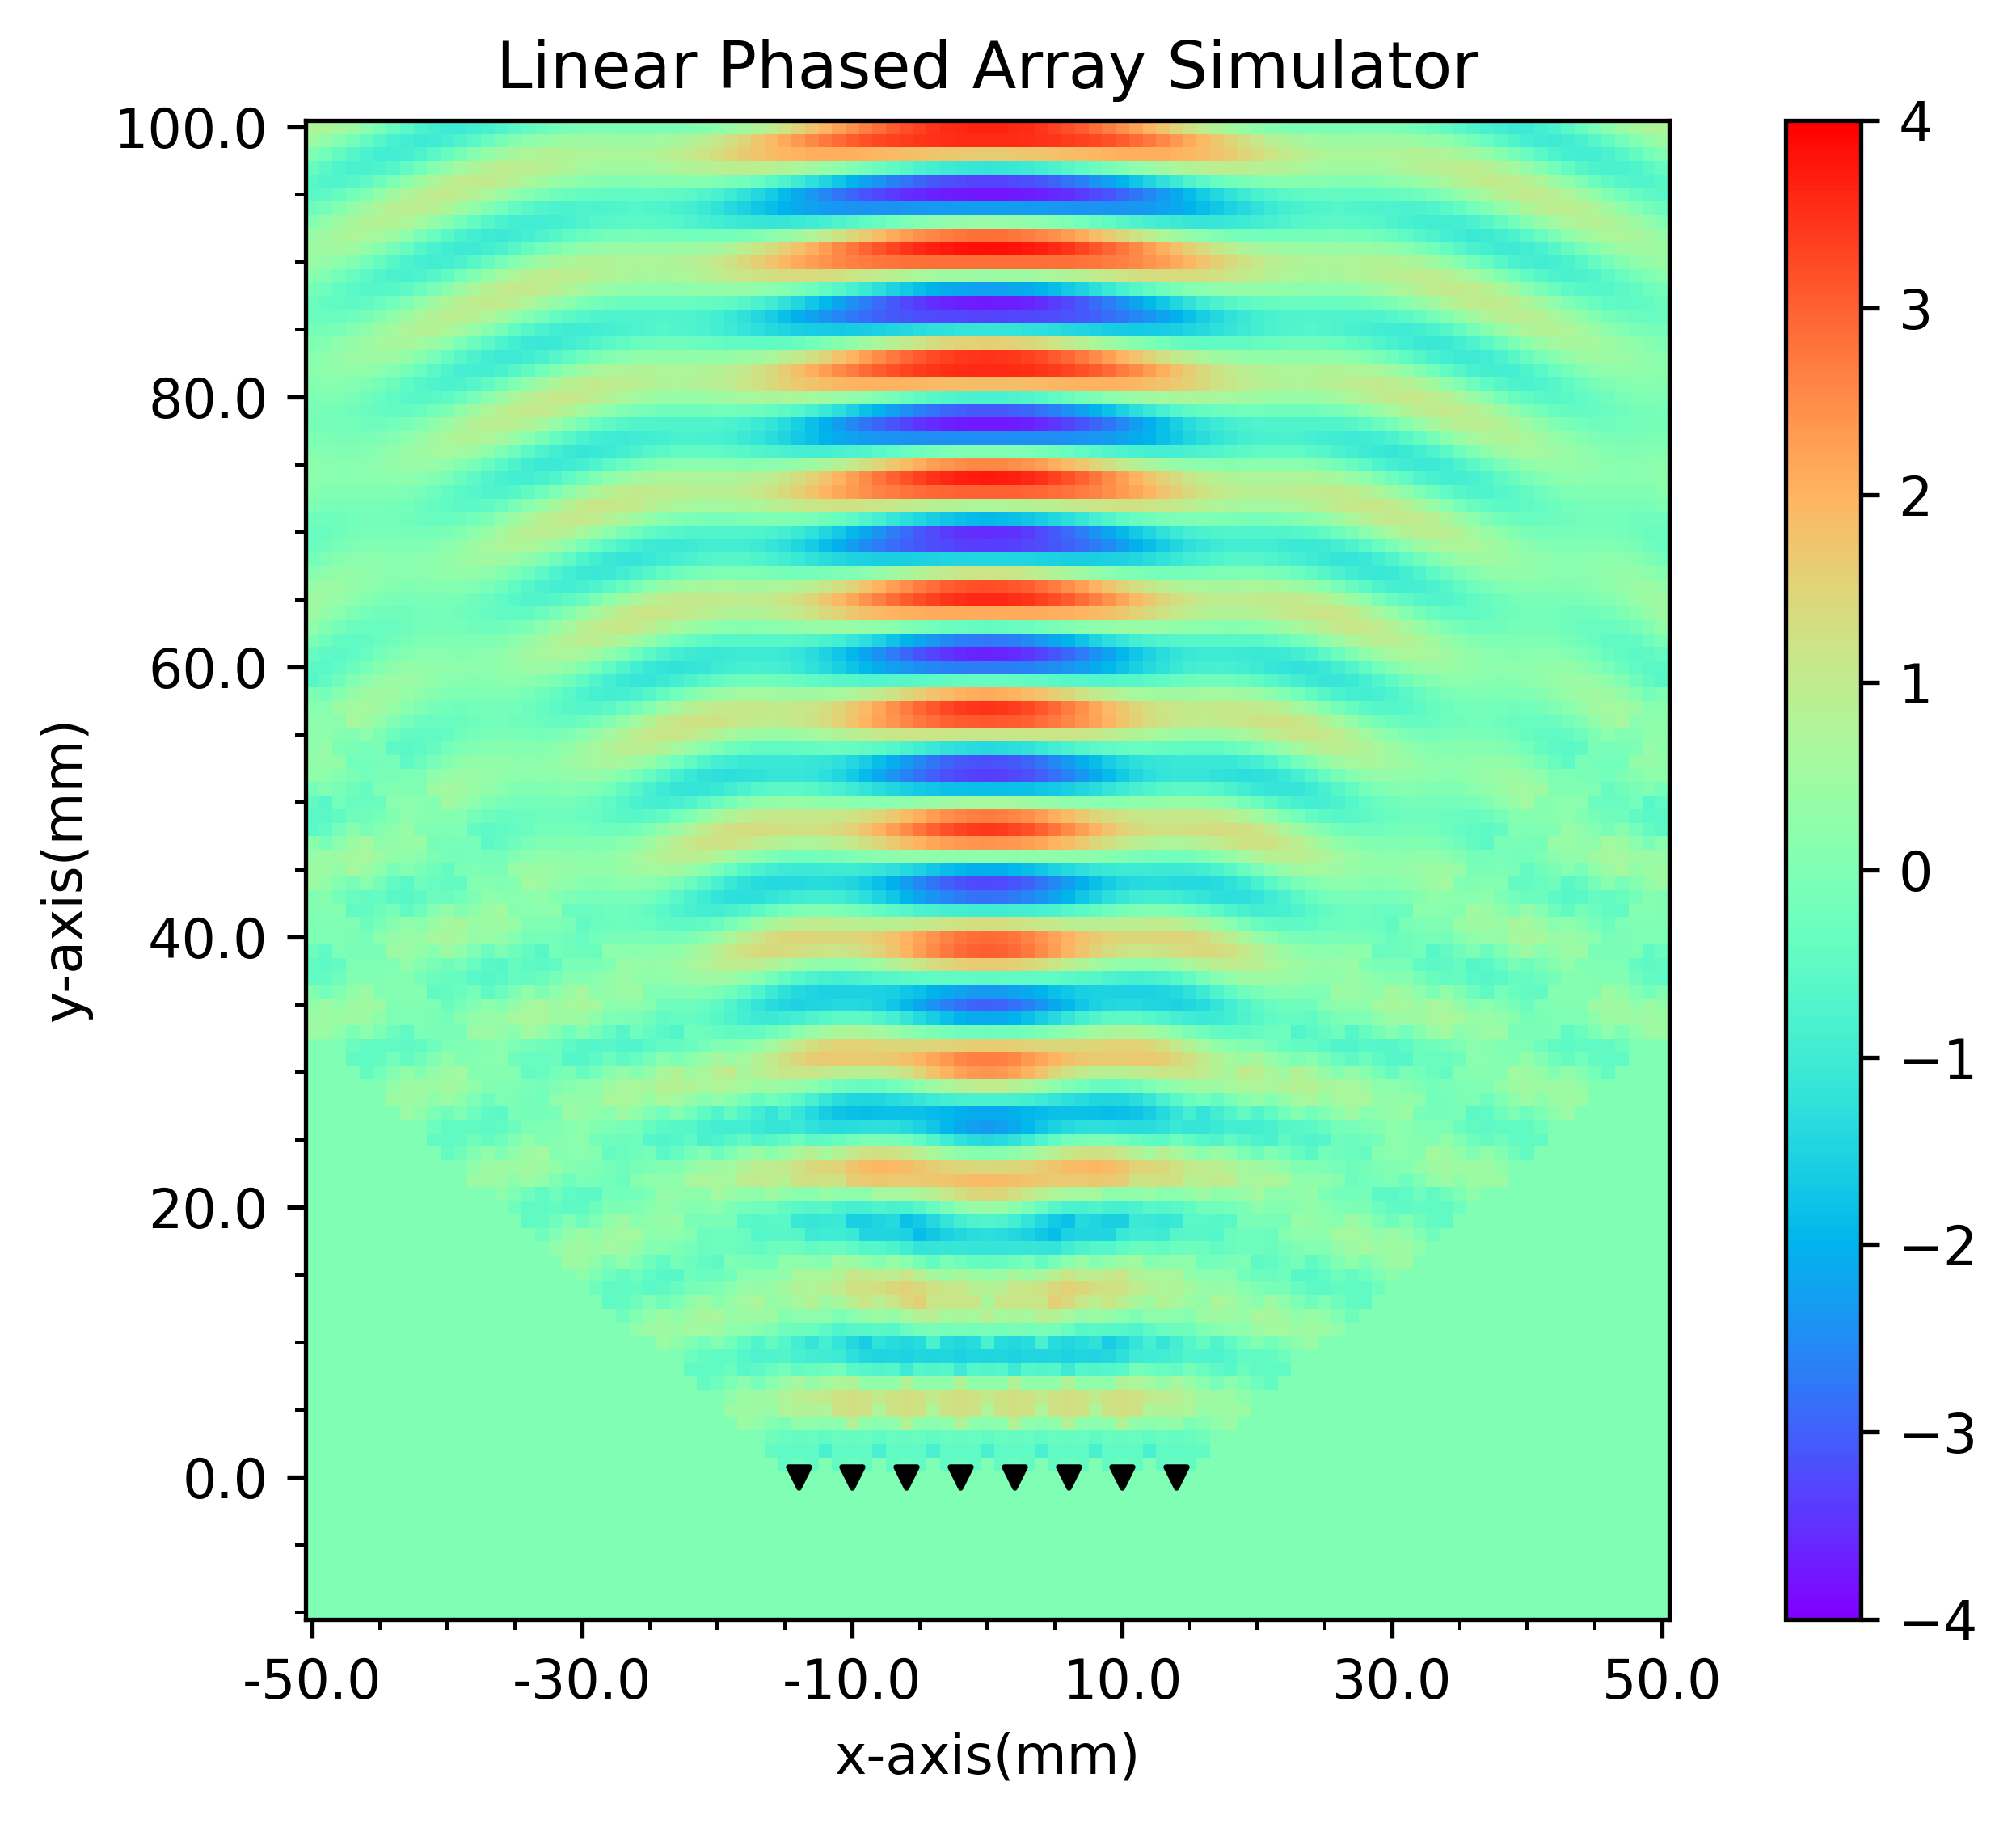

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from PIL import Image

def linear_phased_array_image(A=1, f=40000, v=340.29*1000, t=0, range_x_R=50, range_x_L=-50, range_y_T=100, range_y_B=-10, calc_width=1, tr_num=8, tr_directivity=np.deg2rad(95), tr_clearance=4, tr_marker=True, beam_direction=np.deg2rad(90), use_convergent_mode=False, convergent_point=(0,40), use_grid2image=False, use_gif='disabled', name=0, dura=20):
  # 送信素子をx軸上に原点が中心となる様に配置する。それらの座標を計算してtr_x_coordに格納する。
  tr_x_coord = [] # 送信素子のx座標（y座標は0で固定）
  if (tr_num % 2) == 1: # 送信素子数が奇数個のとき
    for n in range(0, tr_num):
      tr_x_coord.append(-((tr_num // 2) * tr_clearance) + (n * tr_clearance))
  else: # 送信素子数が偶数個のとき
    for n in range(0, tr_num):
      tr_x_coord.append(-(((tr_num // 2) * tr_clearance) - (tr_clearance / 2)) + (n * tr_clearance))

  # 集束モードが有効の場合
  if use_convergent_mode:
    d_ini = np.linalg.norm(np.array([convergent_point[0], convergent_point[1]]) - np.array([tr_x_coord[0], 0])) # 左端の送信素子と集束点の距離

  # 指定されたレンジを満たす（必要最小限は超える）Numpy２次元配列を0埋めで作成する。
  sim_result = np.zeros((int(np.ceil((range_y_T - range_y_B) / calc_width) + 1), int(np.ceil((range_x_R - range_x_L) / calc_width) + 1)))

  calc_x = range_x_L # 計算するx座標を初期化
  calc_y = range_y_T # 計算するy座標を初期化
  row = 0 # 行インデックス初期化
  column = 0 # 列インデックス初期化
  for num in range(0, tr_num): # 送信素子それぞれについて左端から順次計算
    if not use_convergent_mode: # ビームフォーミングモード時の位相差計算
      phase_diff = num * tr_clearance * np.sin(beam_direction - (np.pi / 2)) # 位相差（距離）（ビームフォーミングモード）
    else: # 集束モード時の位相差計算
      phase_diff = np.linalg.norm(np.array([convergent_point[0], convergent_point[1]]) - np.array([tr_x_coord[num], 0])) - d_ini # 位相差（距離）（集束モード）

    while calc_y > (range_y_B - calc_width): # 計算範囲（sim_result）をインデックスの昇順に走査
      while calc_x < (range_x_R + calc_width):
        vec = np.array([calc_x, calc_y]) - np.array([tr_x_coord[num], 0]) # (計算座標) - (送信素子の座標)
        from_tr = np.arctan2(vec[0], vec[1]) # 送信素子から見た計算座標の向き（y軸が0(rad)で、時計回りが正・反時計回りが負となる。）
        if np.abs(from_tr) <= (tr_directivity / 2): # 計算座標が送信素子の指向性の範囲に入っている場合
          sim_result[row][column] += A * np.sin(2 * np.pi * f * (t - (np.linalg.norm(vec) / v) + (phase_diff / v))) # 波の式
        calc_x += calc_width # 次の計算座標へ（x軸の正方向へ）
        column += 1
      calc_x = range_x_L # 計算するx座標を初期化
      column = 0 # 列インデックス初期化
      calc_y -= calc_width # 次の計算座標へ（y軸の負方向へ）
      row += 1
    calc_y = range_y_T # 計算するy座標を初期化
    row = 0 # 行インデックス初期化

  if not use_grid2image:
    # ここからヒートマップの表示設定
    fig, ax = plt.subplots(dpi=480)
    im = ax.imshow(sim_result, cmap='rainbow', aspect='equal', vmin=-A*tr_num, vmax=A*tr_num)
    plt.colorbar(im)
    # x軸目盛りの設定
    ax.set_xticks(np.arange(0, sim_result.shape[1], 1))
    ax.set_xticklabels(np.linspace(range_x_L, range_x_L+(calc_width*(sim_result.shape[1]-1)), sim_result.shape[1]))
    ax.xaxis.set_major_locator(ticker.AutoLocator()) # 過剰に指定された目盛りを自動調整
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator()) # 副目盛りで主目盛りを自動補完
    # y軸目盛りの設定
    ax.set_yticks(np.arange(sim_result.shape[0]-1, 0-1, -1))
    ax.set_yticklabels(np.linspace(range_y_T-(calc_width*(sim_result.shape[0]-1)), range_y_T, sim_result.shape[0]))
    ax.yaxis.set_major_locator(ticker.AutoLocator()) # 過剰に指定された目盛りを自動調整
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator()) # 副目盛りで主目盛りを自動補完
    # タイトル・軸ラベルの設定
    ax.set_title('Linear Phased Array Simulator')
    ax.set_xlabel('x-axis(mm)')
    ax.set_ylabel('y-axis(mm)')
    # 送信素子の位置をプロット（tr_marker=Trueの場合）
    if tr_marker:
      tr_x_coord_idx = []
      for i in range(0, len(tr_x_coord)):
        tr_x_coord_idx.append(np.abs(np.linspace(range_x_L, range_x_L+(calc_width*(sim_result.shape[1]-1)), sim_result.shape[1]) - tr_x_coord[i]).argmin())
      tr_y_coord_idx = [np.abs(np.linspace(range_y_T, range_y_T-(calc_width*(sim_result.shape[0]-1)), sim_result.shape[0]) - 0).argmin()] * len(tr_x_coord)
      ax.scatter(tr_x_coord_idx, tr_y_coord_idx, c='k', marker='v', s=15)
    # 無駄な余白を消す。これは、全てのaxが追加された後に実行されなければならない。
    fig.tight_layout()
    if use_gif == 'disabled':
      name = input("シミュレーション結果を保存します。\nファイル名（拡張子を除く）：")
      plt.savefig(name + '.png', dpi=480)
      return
    else: # アニメーション用番号付き画像保存
      plt.savefig(str(name) + '.png', dpi=480)
      plt.close() # 保存するたびに出力欄に画像が表示されるのを防止
  else:
    fig, ax = plt.subplots(figsize=sim_result.shape[::-1], dpi=1, tight_layout=True)
    ax.imshow(sim_result, cmap='rainbow', aspect='equal', vmin=-A*tr_num, vmax=A*tr_num)
    ax.axis('off')
    if use_gif == 'disabled':
      name = input("シミュレーション結果を保存します。\nファイル名（拡張子を除く）：")
      plt.savefig(name + '.png', dpi=1)
      return
    else: # アニメーション用番号付き画像保存
      plt.savefig(str(name) + '.png', dpi=1)
      plt.close() # 保存するたびに出力欄に画像が表示されるのを防止

  divide = 10
  if name == (divide - 1):
    pictures=[] # 画像を入れる箱を準備
    # 画像を箱に入れていく
    for i in range(0, divide):
      path = str(i) + '.png'
      img = Image.open(path)
      pictures.append(img)
    # gifアニメを出力する
    name_gif = input("シミュレーション結果をGIFアニメーションで保存します。\nファイル名（拡張子を除く）：")
    pictures[0].save(name_gif + '.gif',save_all=True, append_images=pictures[1:], optimize=True, duration=dura, loop=0) # duration = 20ms が下界
    return

  if use_gif == 'periodic_loop':
    linear_phased_array_image(A, f, v, t+((1/f)/divide), range_x_R, range_x_L, range_y_T, range_y_B, calc_width, tr_num, tr_directivity, tr_clearance, tr_marker, beam_direction, use_convergent_mode, convergent_point, use_grid2image, use_gif, name+1, dura)
  elif (use_gif == 'steering') and (not use_convergent_mode):
    linear_phased_array_image(A, f, v, t, range_x_R, range_x_L, range_y_T, range_y_B, calc_width, tr_num, tr_directivity, tr_clearance, tr_marker, beam_direction-((np.pi/2)/divide), use_convergent_mode, convergent_point, use_grid2image, use_gif, name+1, dura)
  elif (use_gif == 'steering') and use_convergent_mode:
    print("［エラー］use_gif='steering'は、ビームフォーミングモード専用のGIF生成機能です。集束モード（use_convergent_mode=True）では、使用できません。")
  else:
    print("［エラー］引数use_gifに、'" + str(use_gif) + "'という設定は存在しません。'periodic_loop'か'steering'のどちらかを指定してください。")

  return

######################### 以下にコードを書きましょう。##########################

linear_phased_array_image(A=1, # A：送信波の振幅(mm)
                          f=40000, # f：送信波の周波数(Hz)
                          v=340.29*1000, # v：送信波の速さ(mm/s)
                          t=0, # t：時間(s)

                          range_x_R=50, # range_x_R：x軸方向レンジ右(mm)
                          range_x_L=-50, # range_x_L：x軸方向レンジ左(mm)
                          range_y_T=100, # range_y_T：y軸方向レンジ上(mm)
                          range_y_B=-10, # range_y_B：y軸方向レンジ下(mm)
                          calc_width=1, # calc_width：計算幅(mm) # 波長の８分の１くらいを推奨

                          tr_num=8, # tr_num：送信素子数（個）
                          tr_directivity=np.deg2rad(95), # tr_directivity：送信素子指向性(rad)
                          tr_clearance=4, # tr_clearance：送信素子間隔(mm) # 半波長以下を推奨
                          tr_marker=True, # tr_marker：送信素子マーカー描写の有無（デフォルト：True）# 計算範囲内に入れないと綺麗に描写されないよ。

                          # ビームフォーミングモード（デフォルト）
                          beam_direction=np.deg2rad(90), # beam_direction：合成波の指向方向(rad)

                          # 集束モード
                          use_convergent_mode=False, # use_convergent_mode：Trueで集束モードを有効化（デフォルト：False）
                          convergent_point=(0,40), # convergent_point：集束点の座標

                          # ２次元配列の要素数に合わせた画像を保存する機能
                          use_grid2image=False, # use_grid2image：Trueで機能を有効化（デフォルト：False）

                          # GIFアニメーションを生成する機能
                          use_gif='disabled', # use_gif：'periodic_loop''steering'のどちらかで有効化（デフォルト：'disabled'）
                          name=0, # name：結果を保存する際に内部的に使用されるファイル名の変数
                          dura=20 # dura：GIFアニメーションの画像１枚あたりの持続時間(ms)
                          )
